# **ECS 7001 - NN & NNLP**

## **Lab 2: LSTM for Text Classification**

<br>

**February 2nd and 3rd**

In Lab 2, you trained word embeddings by casting the unsupervised learning problem as a binary classification problem (i.e. using the skip-gram model). This week, you will build an LSTM model to classify movie reviews as either positive or negative. After training, you will extract the word embeddings learned by the model.



### **0. Prepare the environment**

Open Google Colab or activate the virtual environment you’ve created

### **1. Getting the Dataset**

You will be using the imdb dataset from Lab 0. This is a dataset of 25,000 movie reviews from IMDB, labeled by sentiment - positive (1) or negative (0). 
<br>

The reviews have been preprocessed, and each review is encoded as a list of word indices. Last week, you assigned the indices to the word randomly (or in order of their first appearance in the corpus) but in this preprocessed corpus, the words are indexed by overall frequency in the dataset, such that a word with index 3 occurs more frequently than a word with index 10.
<br>

In the following blocks of code in this section, we will load and visualize the data.


In [ ]:
from tensorflow.keras import datasets

imdb = datasets.imdb

In [ ]:
%%capture

# we'll use the most frequent 10000 words in the vocabulary
VOCAB_SIZE = 10000

# 0 is reserved for ‘<PAD>’, 1 for ‘<START>’ and 2 for ‘<UNK>’ i.e. words not in vocabulary
# the documentation says index_from = 3 but actually uses the value as an offset. The words
# in the dictionary are indexed from 1 by default so, saying index_from=3 means any actual
# words would start from 4 (1+3) and index 3 will be left unused. We use index_from=offset=2 to avoid this
# If you want to explore this further, you may look up the source_code for load_data here
# https://github.com/tensorflow/tensorflow/blob/v2.4.1/tensorflow/python/keras/datasets/imdb.py#L31-L162
OFFSET = 2

# for more information on the load_data method, type(help(load_data))
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words=VOCAB_SIZE, index_from=OFFSET)

***Sanity Check***

Each instance in the training data is a list of word indices representing the words in a movie review.

Each label is 1 if that review is positive, else 0.

In [ ]:
print('Sample review:', train_data[0])

Sample review: [1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 2, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 2, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 2, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


In [ ]:
print('\n Sample label:', train_labels[0])


 Sample label: 1


### **2. Readying the Inputs for the LSTM**

The movie reviews are of different lengths. The standard way of dealing with varying length inputs is to ***pad*** or ***truncate*** each sentence to a fixed length (which we choose heuristically). 

Keras provides a way to do this.  In this section, you will use the keras.preprocessing.sequence method <pad_sequences> handle padding and truncating.

**Hints**

*  help(pad_sequences) will give you more information about how this works.
*  You can experiment with 'pre' vs 'post' padding/truncating. In practice, 'pre' padding is more effective for our purposes; can you hypothesize about why this is?
*  Since we have reserved 0 for \<PAD\>, your pad value should be set to 0.
*  The maximum length has been specified below as MAX_LENGTH.

In [ ]:
from keras.preprocessing.sequence import pad_sequences


MAX_LENGHT = 500

padded_train_data = pad_sequences(train_data, maxlen=MAX_LENGHT, padding='pre', truncating='pre')
padded_test_data = pad_sequences(test_data, maxlen=MAX_LENGHT, padding='pre', truncating='pre')

***Sanity Check***

For the first training example, print its length and the padded sequence to see the effect of your padding process. 

PS: Pre-padding was used for the output you see below.

In [ ]:
print('Length of sample train_data before preprocessing:', len(train_data[0]))
print('Length of sample train_data after preprocessing:', len(padded_train_data[0]))
print('Sample train data:', padded_train_data[0])

Length of sample train_data before preprocessing: 218
Length of sample train_data after preprocessing: 500
Sample train data: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

### **3. Building the Model**

In this section, you will use the keras Model API to build a classification model.

*   The first step is to tell the model what sort of input to expect using the keras \<Input\> layer 
*   The second step is to add an embedding layer like we did last week. 
This embedding layer creates a lookup table of the form {word:embedding} for each of the unique words in our corpus. Use EMBED_SIZE = 100 (i.e each word is represented by a 100D vector such that each movie review is 500 X 100 in dimension.  Don't forget to set mask_zero=True since we are using 0 index as out padding.
*  The third step is to add an LSTM with 100 units. By leaving 'return_sequences' as False, the output of this model will be the output of the final time step of the LSTM. https://keras.io/api/layers/recurrent_layers/lstm/ 
*  The final layer of the model is a fully connected (Dense) layer. Can you figure out what activation function would be appropriate for this layer given the binary nature of the task?
*  The model should be compiled with a 'binary_crossentropy' loss function, an 'adam' optimizer. We also want to visualize the model accuracy during training so the 'metrics' parameter of the compile method should be set to ['accuracy'].

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Reshape
from keras.models import Model

EMBED_SIZE = 100

# add input layer
input_layer = Input(shape=(MAX_LENGHT,))

input_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1, mask_zero=True)(input_layer)

lstm_output = LSTM(units=EMBED_SIZE, return_sequences=False, name='lstm_1')(input_embedding)

# final output layer with classifier
output_layer = Dense(units=1, activation='sigmoid', name='output_layer')(lstm_output)

# compile the model with binary crossentropy loss and adam optimizer
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

***Sanity Check***

Print the model summary and visualize it using vis_utils.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embed_layer (Embedding)     (None, 500, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


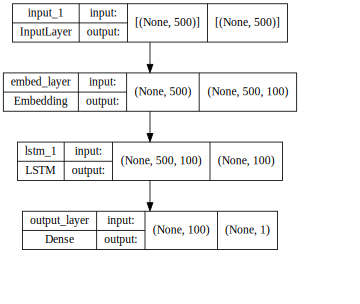

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  


### **4. Training the Model**

A model can memorize the training data (this is called 'overfitting' and when it does so, it's training accuracy can continue to go up but it's accuracy on previously unseen (i.e. non-training) examples can be very poor. To ensure that this doesn't happen, researchers often intermittently check the performance of a model being trained on a held back dataset called the ***validation dataset***. This way, 'early stopping' or 'random search' can be used to select the model that will generalize best to unseen data. 
<br>


In this lab, you will just plot training accuracy against validation accuracy to monitor the progress of your model. And, using the plot, you will theorize about what the optimal stopping point for your model should have been.


**Step 1: Getting a validation dataset**

Before we begin training, you will split the padded training data into training and validation data. To avoid losing too much training data, use 2000 samples (i.e 8%) for validation and the other 23000 for training.

We will do this using the sklearn train_test_split function. 

In [ ]:
from sklearn.model_selection import train_test_split

train_x, validation_x, train_y, validation_y = train_test_split(padded_train_data, train_labels, test_size=0.08) 

Alternatively, we could have chosen to set validation_size=0.08 in our model.fit() function below instead of passing in a separate validation dataset.

**Step 2: Training the model**

We will use model.fit() to train the model. We will set our batch_size to 1000, which means the model will train int(23000/1000) batches each epoch. In other words, at each epoch the model will train 23 batches, each one consisting of 1000 movie reviews.

In [ ]:
history = model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 37s 1s/step - loss: 0.6265 - accuracy: 0.6451 - val_loss: 0.4710 - val_accuracy: 0.7910
Epoch 2/6
23/23 [==============================] - 22s 949ms/step - loss: 0.3790 - accuracy: 0.8531 - val_loss: 0.3176 - val_accuracy: 0.8715
Epoch 3/6
23/23 [==============================] - 22s 955ms/step - loss: 0.2510 - accuracy: 0.9057 - val_loss: 0.2899 - val_accuracy: 0.8875
Epoch 4/6
23/23 [==============================] - 24s 1s/step - loss: 0.1957 - accuracy: 0.9307 - val_loss: 0.2733 - val_accuracy: 0.8960
Epoch 5/6
23/23 [==============================] - 22s 954ms/step - loss: 0.1563 - accuracy: 0.9486 - val_loss: 0.2805 - val_accuracy: 0.8905
Epoch 6/6
23/23 [==============================] - 22s 957ms/step - loss: 0.1289 - accuracy: 0.9593 - val_loss: 0.3006 - val_accuracy: 0.8945


**Step 3: Visualize the model plot**

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=853a66708b858b61019e38a0707fcac1b01238d9a62beac552ef8290b94e8e52
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=bb07f7f482b0764a0a43b085f9d08b0683558df1bf7e4a0a07cb95a1c02ddb44
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=532760eba864f6efef0913648a018ce8b956cd01fa6a663aa40f1f7b4d45ebd9
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

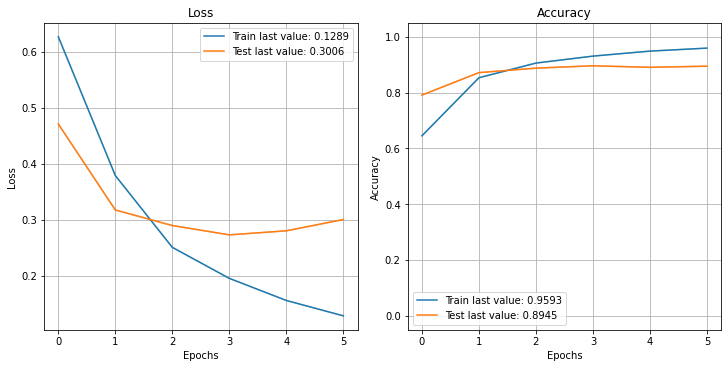

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

**Based on the accuracy plot, what do you think the optimal stopping point for your model should
have been?**

In [ ]:
len(test_data)

25000

### **5. Evaluating the Model on the Test Data**

Evaluate the model on the padded test data using the code in the following cell block.

In [ ]:
# YOUR CODE TO EVALUATE THE MODEL ON TEST DATA GOES HERE
results = model.evaluate(padded_test_data, test_labels)
print('test_loss:', results[0], 'test_accuracy:', results[1])

782/782 [==============================] - 110s 139ms/step - loss: 0.3601 - accuracy: 0.8685
test_loss: 0.3600790500640869 test_accuracy: 0.8684800267219543


###**6. Extracting the Word Embeddings**

Extract the word embeddings from the embedding layer model like we did in the last lab. 

**Hints**

*  You can use model.get_layer(layer_name).get_weights()[0] or model.layers[layer_number].get_weights()[0].  The layer number indicates the order in which the layers were added to the model.

*  If you didn't explicitly name your layers, you can check layer names and numbers about the order from model.summary() or by calling model.layers

In [ ]:
word_embeddings = model.get_layer("embed_layer").get_weights()[0]

***Sanity Check***

Print the shape of the word embeddings using the line of code below. It should return (VOCAB_SIZE, EMBED_SIZE)

In [ ]:
print('Shape of word_embeddings:', word_embeddings.shape)

Shape of word_embeddings: (10000, 100)


###**7. Visualizing the Reviews**

In this section, we will view the effects of padding the dataset. 

As mentioned before, Keras already preprocessed the corpus. In this preprocessed corpus, all the words have already been mapped to indices and were assigned these numbers in order of their frequency such that index 2 is the 2nd most frequent word in the dataset, and so on. However, when we loaded our training dataset, we reserved the first 3 indices - 0, 1, 2 - for \<PAD\>, \<START\> and \<UNK\>. Additionally, we limited our vocabulary to only the top 10000 most frequent words (9997 if you exclude the padding). We will now visualize what a movie review will look like with these changes




**Step 1: Create a word2idx dictionary**

Create the word2idx dictionary using the following lines of code.

In [ ]:
# in this dictionary, the words start from 1, 0 is reserved for padding but 
# <start> and <unknown> are not accounted for.
word_indices = imdb.get_word_index()

# so we shift each original word two places to make room for the two new tokens
offset = 2
word2idx = {k:(v+offset) for k,v in word_indices.items() if v < 9998}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2

1654784/1641221 [==============================] - 0s 0us/step



**Step 2: Create a the idx2word dictionary**

In [ ]:
idx2word = {v:k for k,v in word2idx.items()}


**Step 3: Visualize sample review**

View a sample review text using the lines of code below:

In [ ]:
print(' '.join(idx2word[idx] for idx in train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

###**8. Visualizing the Word_Embeddings**

Visualize the word embeddings for 10 of the words using pandas DataFrame like we did in lab 3

In [ ]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                 0         1         2         3         4         5   \
woods      0.021322 -0.016948  0.016021 -0.001831  0.003546  0.018424   
hanging   -0.028856  0.000362 -0.005027  0.004653  0.011076 -0.019683   
woody     -0.002695  0.018942 -0.016365 -0.008425  0.020334 -0.023362   
arranged  -0.014585 -0.000727 -0.016299 -0.011049  0.006553  0.013894   
bringing   0.008422  0.010303 -0.001404  0.012576  0.019186 -0.013220   
wooden     0.011720 -0.005625  0.011642 -0.028148  0.012258 -0.014192   
errors     0.025149 -0.017638  0.017255 -0.006253 -0.015176  0.020370   
dialogs   -0.026621  0.008397 -0.018563 -0.003514 -0.014060  0.020323   
kids       0.011181  0.007972  0.001516  0.006886 -0.004066  0.011590   
uplifting -0.012604 -0.005350 -0.017992 -0.005206 -0.020141  0.019626   

                 6         7         8         9   ...        90        91  \
woods      0.016331 -0.010687  0.009252  0.009148  ... -0.010355  0.011949   
hanging   -0.023211 -0.002756  0.008896 

###**9. Plot your Word Embeddings using t-SNE**


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


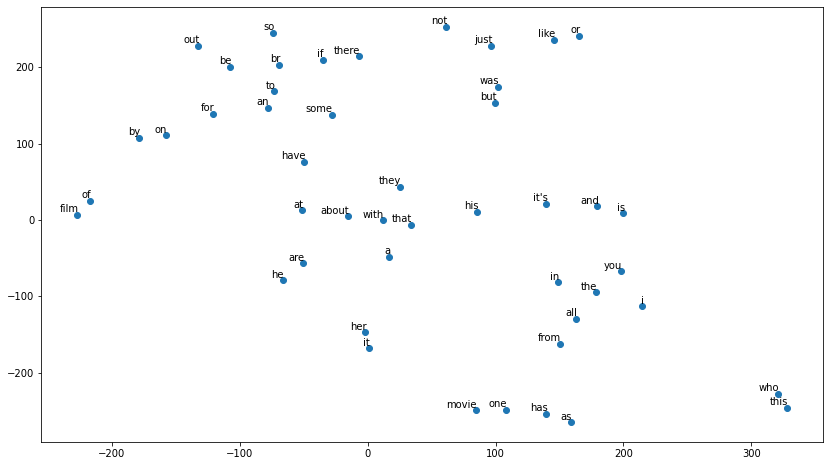

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50

# don't plot the special tokens
start = 3
T = tsne.fit_transform(word_embeddings[start:plot_only, :])
labels = [idx2word[i] for i in range(start, plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        


###**10. Questions**

1. Create a new model that is a copy of the model step 3. To this new model,add two dropout layers, one between the embedding layer and the LSTM layer and another between the LSTM layer and the output layer. Repeat steps 4 and 5 for this model. What do you observe?

2. Experiment with training the model with batch sizes of 1, 32, len(training_data). What do you observe?

3. (optional) Can you retrain with a Bidirectional LSTM instead of an LSTM? What do you observe about the Bi-LSTM model?


In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM, Reshape, Dropout
from keras.models import Model

EMBED_SIZE = 100

# add input layer
new_input_layer = Input(shape=(MAX_LENGHT,))

new_input_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=1, mask_zero=True)(new_input_layer)

# add dropout layer
new_dropout_layer_1 = Dropout(0.2, name='dropout_layer_1')(new_input_embedding)

new_lstm_output = LSTM(units=EMBED_SIZE, return_sequences=False, name='lstm_1')(new_dropout_layer_1)

new_dropout_layer_2 = Dropout(0.2, name='dropout_layer_2')(new_lstm_output)

# final output layer with classifier
new_output_layer = Dense(units=1, activation='sigmoid', name='output_layer')(new_dropout_layer_2)


# compile the model with binary crossentropy loss and adam optimizer
new_model = Model(inputs=new_input_layer, outputs=new_output_layer)
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embed_layer (Embedding)     (None, 500, 100)          1000000   
                                                                 
 dropout_layer_1 (Dropout)   (None, 500, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_layer_2 (Dropout)   (None, 100)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 1,080,501
Trainable params: 1,080,501
Non-tra

In [ ]:
new_history = new_model.fit(train_x, train_y, epochs=6, batch_size=1000, validation_data=(validation_x, validation_y))

Epoch 1/6
23/23 [==============================] - 44s 2s/step - loss: 0.6496 - accuracy: 0.6571 - val_loss: 0.5268 - val_accuracy: 0.7510
Epoch 2/6
23/23 [==============================] - 22s 971ms/step - loss: 0.3746 - accuracy: 0.8487 - val_loss: 0.3145 - val_accuracy: 0.8760
Epoch 3/6
23/23 [==============================] - 22s 969ms/step - loss: 0.2334 - accuracy: 0.9117 - val_loss: 0.2739 - val_accuracy: 0.8940
Epoch 4/6
23/23 [==============================] - 22s 963ms/step - loss: 0.1813 - accuracy: 0.9368 - val_loss: 0.2748 - val_accuracy: 0.8850
Epoch 5/6
23/23 [==============================] - 24s 1s/step - loss: 0.1587 - accuracy: 0.9471 - val_loss: 0.2792 - val_accuracy: 0.8935
Epoch 6/6
23/23 [==============================] - 22s 969ms/step - loss: 0.1386 - accuracy: 0.9545 - val_loss: 0.2819 - val_accuracy: 0.8965


In [ ]:
new_results = new_model.evaluate(padded_test_data, test_labels)
print('test_loss:', new_results[0], 'test_accuracy:', new_results[1])

782/782 [==============================] - 88s 111ms/step - loss: 0.3426 - accuracy: 0.8668
test_loss: 0.3425854742527008 test_accuracy: 0.8667600154876709


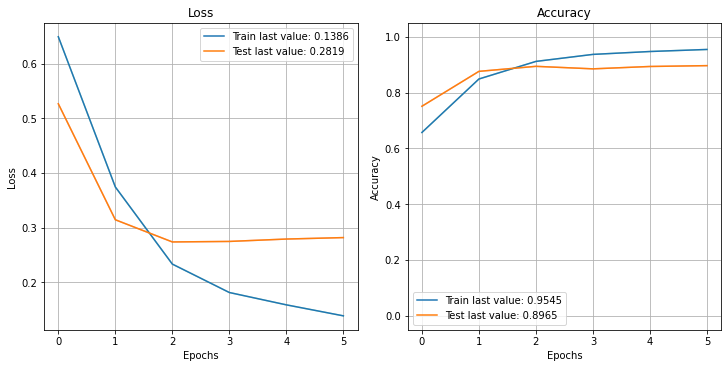

In [ ]:
plot_history(new_history.history, path="standard.png")
plt.show()

In [ ]:
# batch 1

new_history_batch_1 = new_model.fit(train_x, train_y, epochs=6, batch_size=1, validation_data=(validation_x, validation_y))

new_results_batch_1 = new_model.evaluate(padded_test_data, test_labels)
print('test_loss:', new_results_batch_1[0], 'test_accuracy:', new_results_batch_1[1])

# could not train because of google colab restrictions

Epoch 1/6
   11/23000 [..............................] - ETA: 4:43:51 - loss: 1.6410 - accuracy: 0.8182

KeyboardInterrupt: ignored

In [ ]:
# batch 32

new_history_batch_32 = new_model.fit(train_x, train_y, epochs=6, batch_size=32, validation_data=(validation_x, validation_y))

new_results_batch_32 = new_model.evaluate(padded_test_data, test_labels)
print('test_loss:', new_results_batch_32[0], 'test_accuracy:', new_results_batch_32[1])

Epoch 1/6
719/719 [==============================] - 1173s 2s/step - loss: 0.3924 - accuracy: 0.8311 - val_loss: 0.5789 - val_accuracy: 0.6935
Epoch 2/6
719/719 [==============================] - 1128s 2s/step - loss: 0.2857 - accuracy: 0.8890 - val_loss: 0.3668 - val_accuracy: 0.8495
Epoch 3/6
719/719 [==============================] - 1133s 2s/step - loss: 0.1945 - accuracy: 0.9275 - val_loss: 0.3984 - val_accuracy: 0.8400
Epoch 4/6
719/719 [==============================] - 1140s 2s/step - loss: 0.1675 - accuracy: 0.9374 - val_loss: 0.3648 - val_accuracy: 0.8855
Epoch 5/6
719/719 [==============================] - 1161s 2s/step - loss: 0.1157 - accuracy: 0.9598 - val_loss: 0.3898 - val_accuracy: 0.8685
Epoch 6/6
782/782 [==============================] - 85s 109ms/step - loss: 0.4899 - accuracy: 0.8471
test_loss: 0.4899182915687561 test_accuracy: 0.8471199870109558


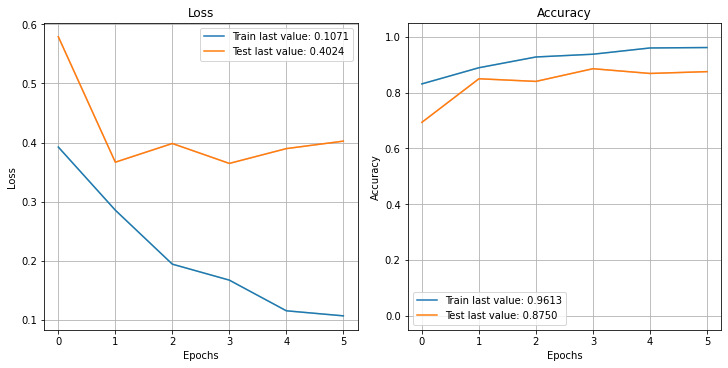

In [ ]:
plot_history(new_history_batch_32.history, path="standard.png")
plt.show()

In [ ]:

new_history_batch_len = new_model.fit(train_x, train_y, epochs=6, batch_size=len(train_x), validation_data=(validation_x, validation_y))

new_results_batch_len = new_model.evaluate(padded_test_data, test_labels)
print('test_loss:', new_results_batch_len[0], 'test_accuracy:', new_results_batch_len[1])

# could not train because of google colab restrictions

Epoch 1/6


ResourceExhaustedError: ignored